In [16]:
import sys
sys.path.append('../')

In [ ]:
# Load models.
import torch
from genwarp import GenWarp

# ZoeDepth
zoedepth = torch.hub.load(
    '../extern/ZoeDepth',
    'ZoeD_N',
    source='local',
    pretrained=True,
    trust_repo=True
).to('cuda')

# GenWarp
genwarp_cfg = dict(
    pretrained_model_path='../checkpoints',
    checkpoint_name='multi1',
    half_precision_weights=True
)
genwarp_nvs = GenWarp(cfg=genwarp_cfg)

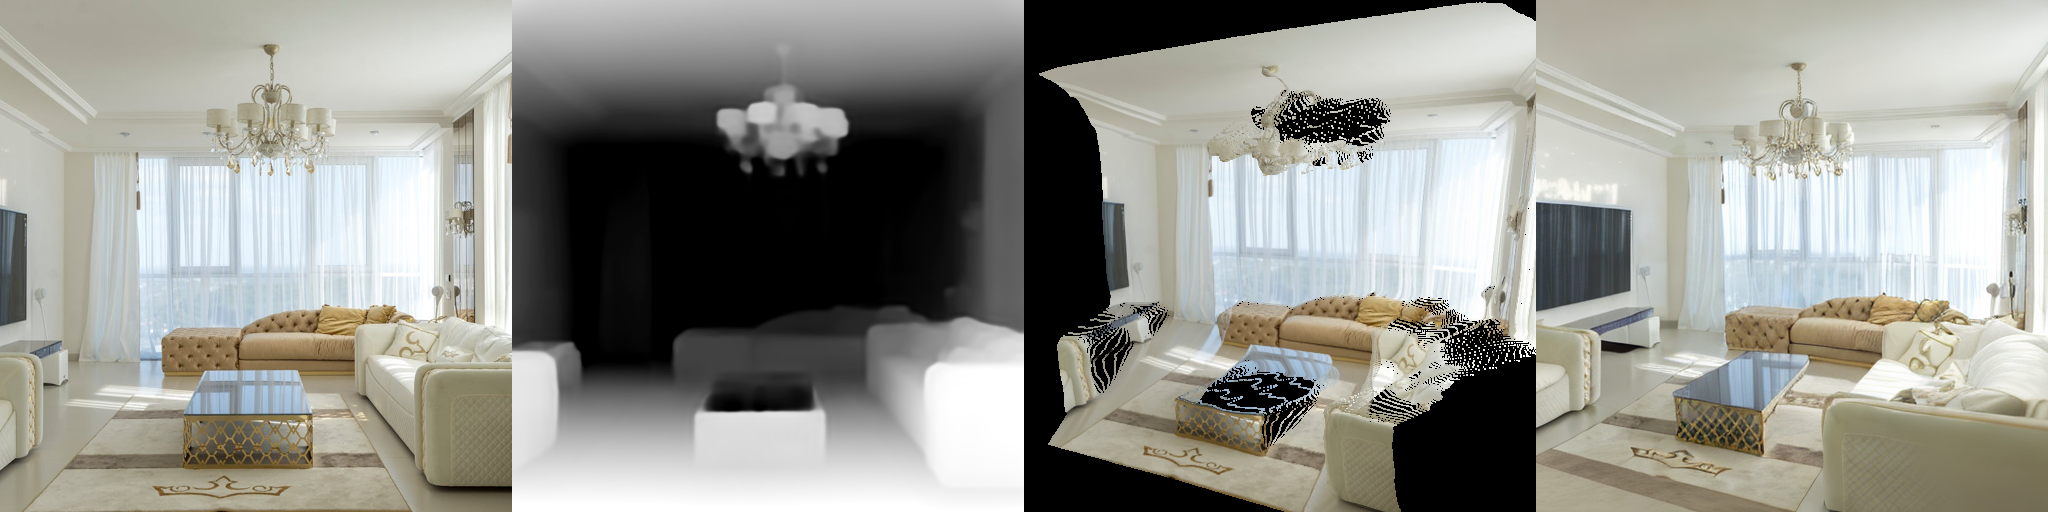

In [19]:
from os.path import basename, splitext

import numpy as np
from PIL import Image

import torch.nn.functional as F
from torchvision.transforms.functional import to_tensor
from torchvision.transforms.functional import to_pil_image

from genwarp.ops import (
    camera_lookat, get_projection_matrix, sph2cart, focal_length_to_fov
)
from extern.ZoeDepth.zoedepth.utils.misc import colorize

# Example image 1.
image_file = '../assets/pexels-heyho-5998120_19mm.jpg'
focal_length_mm = 19  # 35mm full frame equivalent focal length in mm

# Example image 2.
# image_file = '../assets/pexels-itsterrymag-12639296_24mm.jpg'
# focal_length_mm = 24  # 35mm full frame equivalent focal length in mm

# Set the fov if the focal is not available.
# fovy_deg = 55  # in degree

# Resolution (the image will be cropped into square).
res = 512  # in px

# Camera pose settings.
# Camera looks at the center of the scene
azi_deg = 20.  # + -> right
ele_deg = 10.  # + -> up
radius = 0.5  # in meter. <0 -> move closer, >0 -> move away from the scene

# To radian.
azi = torch.tensor(np.deg2rad(azi_deg))
ele = torch.tensor(np.deg2rad(ele_deg))

# Crop the image to the shorter side.
def crop(img: Image) -> Image:
    W, H = img.size
    if W < H:
        left, right = 0, W
        top, bottom = np.ceil((H - W) / 2.), np.floor((H - W) / 2.) + W
    else:
        left, right = np.ceil((W - H) / 2.), np.floor((W - H) / 2.) + H
        top, bottom = 0, H
    return img.crop((left, top, right, bottom))

# Load an image.
src_image = to_tensor(crop(Image.open(
    image_file
).convert('RGB')).resize((res, res)))[None].cuda()  # BCHW
name = splitext(basename(image_file))[0]

# Estimate the depth.
src_depth = zoedepth.infer(src_image)  # BCHW

# Go half precision.
src_image = src_image.half()
src_depth = src_depth.half()

# Projection matrix.
## Using values from ZoeDepth
try:
    fovy = np.deg2rad(fovy_deg)
except Exception:
    fovy = focal_length_to_fov(focal_length_mm, 24.)
fovy = torch.ones(1) * fovy
near, far = 0.01, 100
src_proj_mtx = get_projection_matrix(
    fovy=fovy,
    aspect_wh=1.,
    near=near,
    far=far
).to(src_image)
## Use the same projection matrix for the source and the target.
tar_proj_mtx = src_proj_mtx

## Reference camera for ZoeDepth.
z_up = torch.tensor([[0., 0., 1.]])
### world: z-up, y-right, x-back
src_view_mtx = camera_lookat(
    torch.tensor([[0., 0., 0.]]),  # From (0, 0, 0)
    torch.tensor([[-1., 0., 0.]]), # Cast rays to -x
    z_up  # z-up
)

## Target camera.
mean_depth = src_depth.mean(dim=(2, 3)).squeeze(1).cpu()

# Camera path view matrices.
## View from
eye = sph2cart(azi, ele, mean_depth + radius).float()
## View at
at = F.pad(-mean_depth[:, None], (0, 2), mode='constant', value=0)
## Calculate the view matrix.
tar_view_mtx = camera_lookat(
    eye + at,  # Move camera relative to the scene.
    at,  # Looking at the center of the scene.
    z_up  # z-up
)

## Relative camera pose from the target eye coords to reference eye coords.
rel_view_mtx = (
    tar_view_mtx @ torch.linalg.inv(src_view_mtx.float())
).to(src_image)

# GenWarp.
renders = genwarp_nvs(
    src_image=src_image,
    src_depth=src_depth,
    rel_view_mtx=rel_view_mtx,
    src_proj_mtx=src_proj_mtx,
    tar_proj_mtx=tar_proj_mtx
)

warped = renders['warped']
synthesized = renders['synthesized']

# To pil image.
src_pil = to_pil_image(src_image[0])
depth_pil = to_pil_image(colorize(src_depth[0].float()))
warped_pil = to_pil_image(warped[0])
synthesized_pil = to_pil_image(synthesized[0])

# Visualise.
vis = Image.new('RGB', (res * 4, res * 1))
vis.paste(src_pil, (res * 0, 0))
vis.paste(depth_pil, (res * 1, 0))
vis.paste(warped_pil, (res * 2, 0))
vis.paste(synthesized_pil, (res * 3, 0))
vis